In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

<h1>Reading Data</h1>

In [2]:
headers = ["Age", "WorkClass", "FnlWgt", "Education", "EducationNum",
           "MaritalStatus", "Occupation", "Relationship",
          "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", 
           "NativeCountry", "Income"]

In [3]:
train = pd.read_csv("../data/census-income.data", names = headers)
test = pd.read_csv("../data/census-income.test", skiprows = 1, names = headers)

In [4]:
train.head()

,Age,WorkClass,FnlWgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test.head()

,Age,WorkClass,FnlWgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


<h1>Cleaning Data</h1>
<p>The Data contains extra spaces and dots and null values. Cleaning the data to remove these values.</p>

In [6]:
numerical = []
categorical = []

for header in headers:
    if train[header].dtype != np.dtype("int64"):
        categorical.append(header)
        train[header] = train[header].map(lambda x:x.strip(" "))
    else:
        numerical.append(header)

In [7]:
for header in headers:
    if test[header].dtype != np.dtype("int64"):
        test[header] = test[header].map(lambda x:x.strip(" "))

In [8]:
test["Income"] = test["Income"].map(lambda x:x.strip("."))

In [9]:
train = train.replace("?", np.nan)
test = test.replace("?", np.nan)

In [10]:
train.dropna(how = "any", inplace = True)
test.dropna(how = "any", inplace = True)

In [11]:
train.head()

,Age,WorkClass,FnlWgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
test.head()

,Age,WorkClass,FnlWgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


<h1>Saving the cleaned data</h1>

In [13]:
train.to_csv("../data/censusTrain.csv", index = False)
test.to_csv("../data/censusTest.csv", index = False)

<h1>Loading the cleaned data</h1>

In [14]:
train = pd.read_csv("../data/censusTrain.csv")
test = pd.read_csv("../data/censusTest.csv")

In [15]:
train.head()

,Age,WorkClass,FnlWgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [16]:
test.head()

,Age,WorkClass,FnlWgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


<h1>Data Summary</h1>

In [17]:
def dataDescription(data):
    for column in data.columns:
        print(column)
        if data.dtypes[column] != np.dtype("int64"):
            print(data[column].value_counts())
        else:
            print(data[column].describe()) 
        print('\n')

In [18]:
dataDescription(train)

Age
count    30162.000000
mean        38.437902
std         13.134665
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: Age, dtype: float64


WorkClass
Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: WorkClass, dtype: int64


FnlWgt
count    3.016200e+04
mean     1.897938e+05
std      1.056530e+05
min      1.376900e+04
25%      1.176272e+05
50%      1.784250e+05
75%      2.376285e+05
max      1.484705e+06
Name: FnlWgt, dtype: float64


Education
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: Ed

<h1>Visualization</h1>

In [19]:
def visualizeCategoricalData(data, features, hue, size):
    plots = len(features)
    cols = 2
    rows = plots//cols

    fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (size*cols, size*rows), constrained_layout = True)

    for position, category in enumerate(features):
        row = position // cols
        col = position % cols

        plot = sns.countplot(y = category, hue = hue, data = data, ax = axs[row][col])

In [20]:
def visualizeNumericalData(data, features):
    plt.figure(figsize = (10, 10))
    ax = sns.heatmap(data[features].corr(), annot = True, fmt='.1g', vmin = -1, vmax = 1, center = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

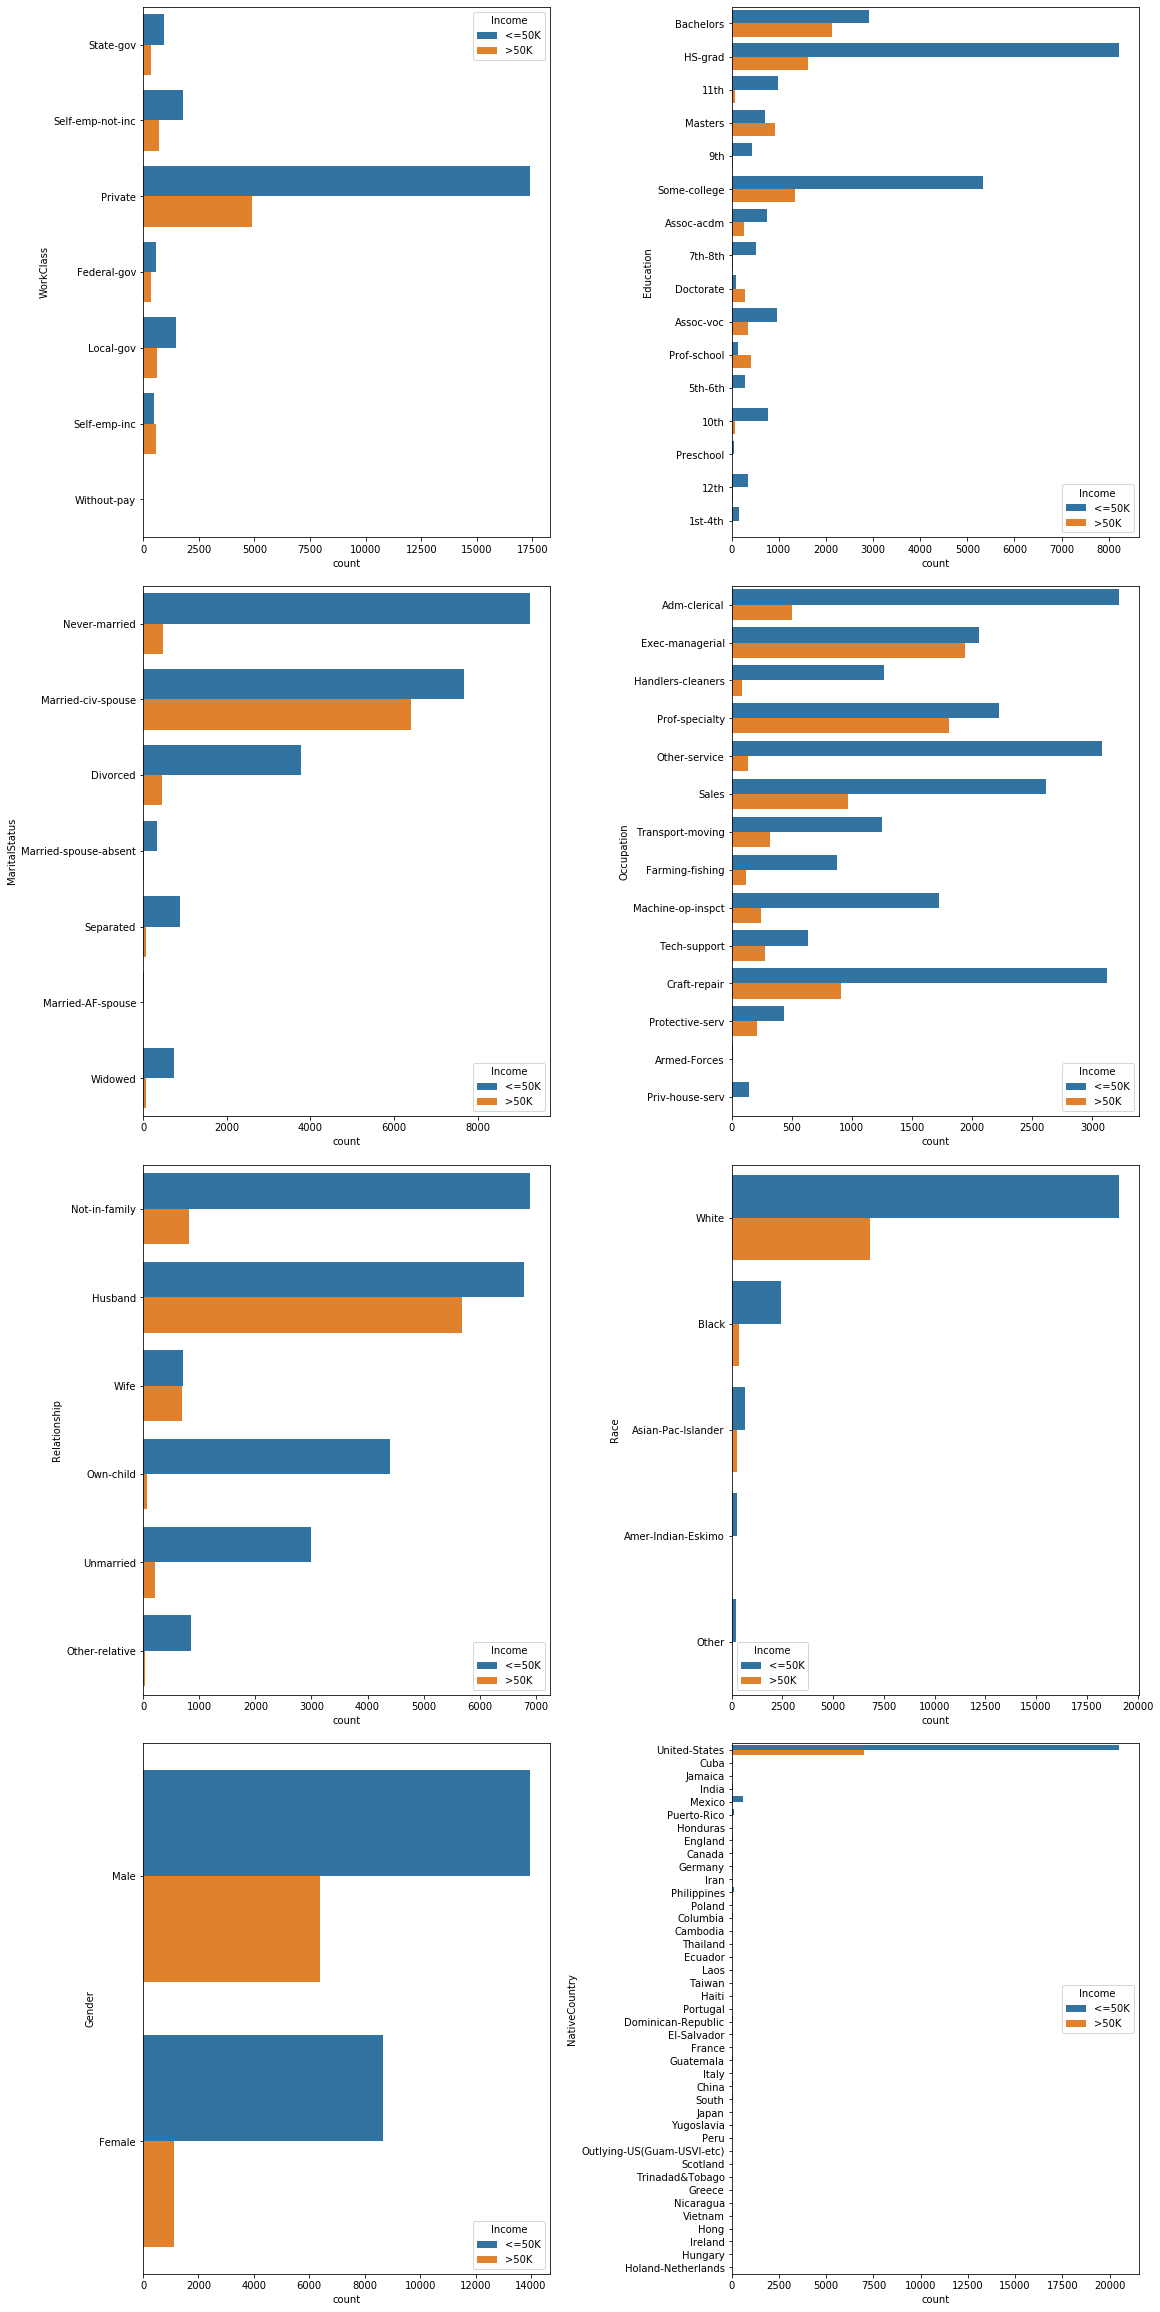

In [21]:
visualizeCategoricalData(train, categorical[:-1], "Income", 8)

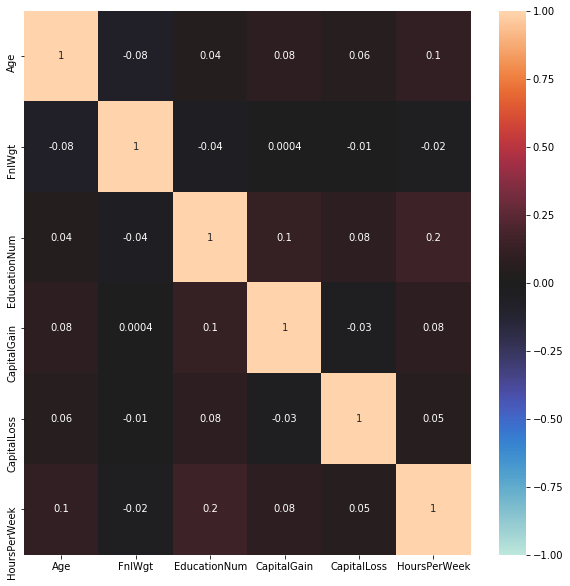

In [22]:
visualizeNumericalData(train, numerical)

<h1>Numerical Encoding of categorical Data</h1>

In [23]:
train[["Education", "EducationNum"]].head(15)

,Education,EducationNum
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13
5,Masters,14
6,9th,5
7,HS-grad,9
8,Masters,14
9,Bachelors,13


<p>As we can see above that, the columns Eduaction and EduactionNum are both the same, EduactionNum is the numerical encoding of Eduaction. So, we can drop one. It is ideal to drop Eduaction becuase while model numerical features like EduactionNum are required.</p>

In [24]:
educationMappings = train[["Education", "EducationNum"]].drop_duplicates()
train = train.drop(columns = ["Education"])
test = test.drop(columns = ["Education"])

In [25]:
educationMappings

,Education,EducationNum
0,Bachelors,13
2,HS-grad,9
3,11th,7
5,Masters,14
6,9th,5
10,Some-college,10
13,Assoc-acdm,12
14,7th-8th,4
19,Doctorate,16
45,Assoc-voc,11


In [26]:
train.head()

,Age,WorkClass,FnlWgt,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [27]:
test.head()

,Age,WorkClass,FnlWgt,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,198693,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


<p>Similarly, we want to encode every other categorical feature into numerical. We cannot encode them in same way as the Education and EducationNum because the other feature are not all ordinal like these two. So, we can either proceed with one hot encoding.</p>

In [28]:
def categoricalToNumerical(data):
    for column in data.columns[:-1]:
        if data.dtypes[column] != np.dtype("int64"):
            data = data.join(pd.get_dummies(data[column])).drop(column, 1)
        else:
             data = data.drop(column, 1).join(data[column])
    data = data.drop("Income", 1).join(data["Income"])
    return data

In [29]:
train = categoricalToNumerical(train)
test = categoricalToNumerical(test)
test.insert(test.columns.get_loc("Haiti")+1, "Holand-Netherlands", 0)

In [30]:
train.head()

,Age,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,FnlWgt,EducationNum,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,Income
0,39,0,0,0,0,0,1,0,77516,13,...,0,0,0,0,0,0,1,0,0,<=50K
1,50,0,0,0,0,1,0,0,83311,13,...,0,0,0,0,0,0,1,0,0,<=50K
2,38,0,0,1,0,0,0,0,215646,9,...,0,0,0,0,0,0,1,0,0,<=50K
3,53,0,0,1,0,0,0,0,234721,7,...,0,0,0,0,0,0,1,0,0,<=50K
4,28,0,0,1,0,0,0,0,338409,13,...,0,0,0,0,0,0,0,0,0,<=50K


In [31]:
test.head()

,Age,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,FnlWgt,EducationNum,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,Income
0,25,0,0,1,0,0,0,0,226802,7,...,0,0,0,0,0,0,1,0,0,<=50K
1,38,0,0,1,0,0,0,0,89814,9,...,0,0,0,0,0,0,1,0,0,<=50K
2,28,0,1,0,0,0,0,0,336951,12,...,0,0,0,0,0,0,1,0,0,>50K
3,44,0,0,1,0,0,0,0,160323,10,...,0,0,0,0,0,0,1,0,0,>50K
4,34,0,0,1,0,0,0,0,198693,6,...,0,0,0,0,0,0,1,0,0,<=50K


In [32]:
incomeMapping = {"<=50K" : 0, ">50K" : 1}

In [33]:
train = train.replace("<=50K", 0).replace(">50K", 1)
test = test.replace("<=50K", 0).replace(">50K", 1)

In [34]:
train.head()

,Age,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,FnlWgt,EducationNum,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,Income
0,39,0,0,0,0,0,1,0,77516,13,...,0,0,0,0,0,0,1,0,0,0
1,50,0,0,0,0,1,0,0,83311,13,...,0,0,0,0,0,0,1,0,0,0
2,38,0,0,1,0,0,0,0,215646,9,...,0,0,0,0,0,0,1,0,0,0
3,53,0,0,1,0,0,0,0,234721,7,...,0,0,0,0,0,0,1,0,0,0
4,28,0,0,1,0,0,0,0,338409,13,...,0,0,0,0,0,0,0,0,0,0


In [35]:
test.head()

,Age,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,FnlWgt,EducationNum,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,Income
0,25,0,0,1,0,0,0,0,226802,7,...,0,0,0,0,0,0,1,0,0,0
1,38,0,0,1,0,0,0,0,89814,9,...,0,0,0,0,0,0,1,0,0,0
2,28,0,1,0,0,0,0,0,336951,12,...,0,0,0,0,0,0,1,0,0,1
3,44,0,0,1,0,0,0,0,160323,10,...,0,0,0,0,0,0,1,0,0,1
4,34,0,0,1,0,0,0,0,198693,6,...,0,0,0,0,0,0,1,0,0,0


In [36]:
trainList = train.values.tolist()
trainFeatures = []
trainY = []
for t in trainList:
    trainFeatures.append(t[:-1])
    trainY.append(t[-1])

In [37]:
testList = test.values.tolist()
testFeatures = []
testY = []
for t in testList:
    testFeatures.append(t[:-1])
    testY.append(t[-1])

<h1>Modeling</h1>

<h1>Logistic Regression</h1>

In [38]:
def logisticRegression(x, y, alpha):
    x = np.array(x)
    y = np.array(y)
    weight = np.zeros(len(x[0]))
    for step in range(1000):
        weight = weight + (alpha * np.dot(x.T, y - predict(weight, x)))
    return weight

In [39]:
def predict(weights, features):
    return 1/(1 + np.exp(-1*(np.dot(features, weights))))

In [40]:
def error(weights, data):
    errors = [abs(data[1][i] - predict(weights, data[0][i]))for i in range(len(data[0]))]
    return sum(errors)/len(errors)

In [41]:
featuresTrain = [] 
featuresTest = []

for t in trainFeatures:
    featuresTrain.append([1] + t)

for t in testFeatures:
    featuresTest.append([1] + t)

In [42]:
weights = logisticRegression(featuresTrain, trainY, 0.05)

In [43]:
predict(weights, featuresTest[0])

0.0

In [44]:
error(weights, [featuresTest, testY])

0.23751660026560426

<h1>KNN</h1>

In [45]:
def euclideanDistance(a, b):
    distance = 0
    for i in range(len(a)):
        distance += (a[i] - b[i])**2
    return (distance)**0.5

In [46]:
def kNearestNeighbors(train, test, k):
    distance = []
    for t in train:
        distance.append((t[-1],euclideanDistance(t[:-1], test)))
    distance.sort(key=lambda x: x[1])
    # print("top k neighbours : ", distance[:k])
    return [distance[i][0] for i in range(k)]

In [47]:
def predict(train, test, k):
    neighbors = kNearestNeighbors(train, test, k)
    return max(Counter(neighbors).items(), key=lambda x: x[1])[0]

In [48]:
def error(train, features, y, k):
    errors = [abs(y[i] - predict(train, features[i], k))for i in range(len(features))]
    return sum(errors)/len(errors)

In [49]:
predict(trainList[1:], trainList[0][:-1], 2)

0

In [50]:
error(trainList, testFeatures[:100], testY[:100], 5)

0.13